In [1]:
# Let's extract all the nodes first.

import overpass

master_query = 'area[name = "New Delhi"]; node(area)[shop];'

api_endpoint = overpass.API(endpoint='https://lz4.overpass-api.de/api/interpreter', debug=True)

response = api_endpoint.get(master_query)

INFO:root:area[name = "New Delhi"]; node(area)[shop];
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): lz4.overpass-api.de:443


[out:json];area[name = "New Delhi"]; node(area)[shop];out body;
send: b'POST /api/interpreter HTTP/1.1\r\nHost: lz4.overpass-api.de\r\nUser-Agent: python-requests/2.22.0\r\nAccept-Encoding: gzip, deflate\r\nAccept: */*\r\nConnection: keep-alive\r\nAccept-Charset: utf-8;q=0.7,*;q=0.7\r\nContent-Length: 100\r\nContent-Type: application/x-www-form-urlencoded\r\n\r\n'
send: b'data=%5Bout%3Ajson%5D%3Barea%5Bname+%3D+%22New+Delhi%22%5D%3B+node%28area%29%5Bshop%5D%3Bout+body%3B'


DEBUG:urllib3.connectionpool:https://lz4.overpass-api.de:443 "POST /api/interpreter HTTP/1.1" 200 11237


reply: 'HTTP/1.1 200 OK\r\n'
header: Date: Sun, 13 Oct 2019 12:42:16 GMT
header: Server: Apache/2.4.18 (Ubuntu)
header: Vary: Accept-Encoding
header: Content-Encoding: gzip
header: Content-Length: 11237
header: Keep-Alive: timeout=5, max=100
header: Connection: Keep-Alive
header: Content-Type: application/json
application/json


In [2]:
# A little bit of preprocessing because GeoJSON seems hard.

data = list(response.values())[1]
dict_data = []

available_categories = {}

for elem in data:
    category = elem['properties']['shop']
    available_categories.setdefault(category, 0)
    available_categories[category] += 1
    current_dict = {'id': elem['id'],
                    'type': category,
                    'coordinates': elem['geometry']['coordinates']}
    dict_data.append(current_dict)

In [3]:
available_categories = dict(sorted(available_categories.items(), key=lambda x: x[1]))

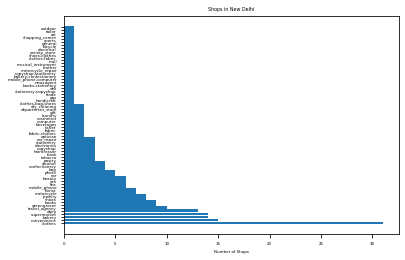

In [6]:
import matplotlib.pyplot as plt
import matplotlib

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 4}

matplotlib.rc('font', **font)

fig, ax = plt.subplots()

shop_cat = list(available_categories.keys())
y_pos = range(len(shop_cat))
shop_freq = list(available_categories.values())

ax.barh(y_pos, shop_freq, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(shop_cat)
ax.invert_yaxis()
ax.set_xlabel('Number of Shops')
ax.set_title('Shops in New Delhi')

plt.savefig('ShopCategories.png', dpi=300)

In [7]:
# Forming class tags
tag_list = {}
i = 0
for elem in available_categories:
    tag_list[elem] = i
    i = i + 1

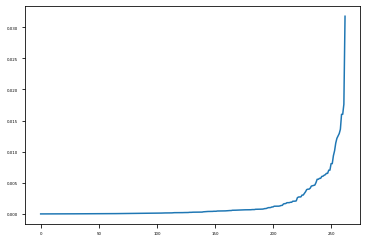

In [56]:
# Finding distance between two points
import pandas as pd
data_matrix = pd.DataFrame([elem['coordinates'] for elem in dict_data], columns = ['lon', 'lat'], index=[elem['id'] for elem in dict_data])

from scipy.spatial import distance_matrix
distance_matrix = pd.DataFrame(distance_matrix(data_matrix.values, data_matrix.values), index=data_matrix.index, columns=data_matrix.index)

# Filling diagonals with a high value so they're not included in the 
import numpy as np
np.fill_diagonal(distance_matrix.values, 9999)

# Finding the lowest distance in every row from distance matrix for finding out Epsilon Distance in DBSCAN
eps_distance = []
for elem in distance_matrix.index:
    eps_distance.append(distance_matrix[elem].min())
    
eps_distance = np.sort(eps_distance)

# Plotting the nearest neighbor distance array
plt.plot(eps_distance)
plt.savefig('eps_distance', dpi=300)

# The point of maximum curvature should be about ~ 0.007 but the 0.007, which is roughly equivalent to 1KM, but 0.006 forms 14 clusters, compared to 13 with 0.007

In [61]:
# DBSCAN Preprocessing 

data_np = data_matrix.to_numpy()

In [143]:
db = DBSCAN(eps=0.006).fit(data_np)

In [144]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool) 
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_ 

In [145]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) 

In [146]:
unique_labels = set(labels)

In [148]:
# Generating random colors according to cluster
import random
r = lambda: random.randint(0,255)
unique_colors = ['#%02X%02X%02X' % (r(),r(),r()) for elem in unique_labels]

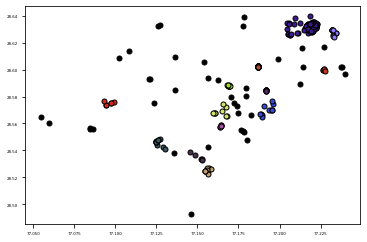

In [247]:
# Plotting clusters
# from mpl_toolkits.basemap import Basemap
# m = Basemap(llcrnrlon=77.338600,llcrnrlat=28.683962,urcrnrlon=77.109947,urcrnrlat=28.529337, epsg=3857)
# m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 1500, verbose= True)
for k, col in zip(unique_labels, unique_colors): 
    if k == -1: 
        # Black used for noise. 
        col = 'k'
  
    class_member_mask = (labels == k) 
  
    xy = data_np[class_member_mask & core_samples_mask] 
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, 
                                      markeredgecolor='k',  
                                      markersize=5) 
  
    xy = data_np[class_member_mask & ~core_samples_mask] 
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, 
                                      markeredgecolor='k', 
                                      markersize=5)

plt.savefig('Clusters_Mapped.png', dpi=300)

In [220]:
# Let's print some properties of these clustesr
# size, types of shops, average distance between shops
clusters = {}
for i in labels:
    clusters.setdefault(i, [])
    clusters[i].append(dict_data[i])

In [231]:
for cluster in clusters:
    print("***********************\nSize of Cluster: {}\n")
    temp = [elem[] for elem in cluster]

14

In [238]:

clusters[0]

[{'id': 438038593,
  'type': 'supermarket',
  'coordinates': [77.156189, 28.524796]},
 {'id': 438038593,
  'type': 'supermarket',
  'coordinates': [77.156189, 28.524796]},
 {'id': 438038593,
  'type': 'supermarket',
  'coordinates': [77.156189, 28.524796]},
 {'id': 438038593,
  'type': 'supermarket',
  'coordinates': [77.156189, 28.524796]},
 {'id': 438038593,
  'type': 'supermarket',
  'coordinates': [77.156189, 28.524796]},
 {'id': 438038593,
  'type': 'supermarket',
  'coordinates': [77.156189, 28.524796]},
 {'id': 438038593,
  'type': 'supermarket',
  'coordinates': [77.156189, 28.524796]},
 {'id': 438038593,
  'type': 'supermarket',
  'coordinates': [77.156189, 28.524796]},
 {'id': 438038593,
  'type': 'supermarket',
  'coordinates': [77.156189, 28.524796]}]